# Connection to Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Library

In [ ]:
# Modul standar Python
import os  # Operasi sistem
import random  # Fungsi-fungsi acak
import shutil  # Operasi-operasi file dan direktori
import zipfile  # Operasi-operasi file zip
import re  # Operasi regular expression

# Modul untuk pengolahan gambar
import cv2  # Pengolahan gambar dengan OpenCV
from google.colab.patches import cv2_imshow  # Menampilkan gambar di Colab

# Modul untuk analisis data dan visualisasi
import numpy as np  # Operasi-operasi numerik
import pandas as pd  # Struktur data dan analisis data
import matplotlib.pyplot as plt  # Visualisasi data
import seaborn as sns  # Visualisasi data yang lebih interaktif
from sklearn.metrics import classification_report, confusion_matrix  # Evaluasi klasifikasi
from shutil import copyfile  # Menyalin file

# Modul TensorFlow dan Keras
import tensorflow as tf  # Framework machine learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Pemrosesan gambar
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Konversi gambar ke array dan memuat gambar
from tensorflow.keras.optimizers import Adam, RMSprop  # Optimizer untuk model
from tensorflow.keras import layers, models  # Pembuatan model
from tensorflow.keras.callbacks import EarlyStopping  # Penghentian dini dalam pelatihan model

tf.keras.utils.set_random_seed(42)  # Pengaturan seed untuk reproduktibilitas


# Load data di Folder Google Drive untuk Akses Dataset

In [ ]:
dataset_dir = f"drive/Shareddrives/Bangkit/datasetsoil/inceptiondata"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")
validation_dir = os.path.join(dataset_dir, "validation")

In [ ]:
def count_images():
    # List direktori kelas pada setiap dataset
    train_classes_dirs = os.listdir(train_dir)
    for folder in train_classes_dirs:
        # Mendapatkan jumlah gambar pada setiap dataset: train, validation, dan test
        train_classes = os.listdir(os.path.join(train_dir, folder))
        validation_classes = os.listdir(os.path.join(validation_dir, folder))
        test_classes = os.listdir(os.path.join(test_dir, folder))

        # Menampilkan informasi jumlah gambar untuk setiap kelas
        print(f"Class: {folder}")
        print(f"\tTrain: {len(train_classes)} images")
        print(f"\tValidation: {len(validation_classes)} images")
        print(f"\tTest: {len(test_classes)} images")
        total_images = len(train_classes) + len(validation_classes) + len(test_classes)
        print(f"\tTotal: {total_images} images")
        print()

count_images()

Class: Aluvial
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Andosol
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Entisol
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Humus
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Inceptisol
	Train: 71 images
	Validation: 25 images
	Test: 15 images
	Total: 111 images

Class: Laterit
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Kapur
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images

Class: Pasir
	Train: 70 images
	Validation: 25 images
	Test: 15 images
	Total: 110 images



# Plot and Labeling Data

In [ ]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def preprocess_image(self,img):
    # img = cv2.resize(img, (224,224))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # find the green color
    mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
    mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
    # find the yellow color in the leaf
    mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

    # find any of the three colors(green or brown or yellow) in the image
    mask = cv2.bitwise_or(mask_green, mask_brown)
    mask = cv2.bitwise_or(mask, mask_yellow)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)

    return res



  def create_data_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range = 25,
      zoom_range = [0.5, 1.1],
      width_shift_range=0.15,
      shear_range= 0.15,
      height_shift_range=0.15,
      horizontal_flip=True,
      vertical_flip= True,
      fill_mode='nearest',)

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))

    validation_datagen = ImageDataGenerator(rescale = 1/255,)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    test_datagen = ImageDataGenerator(rescale= 1./255.)

    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False,
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generators(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator


  def build(self, compile_config, custom_layer = None):

    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    layers = []

    # Append base model to layers_list
    layers.append(self.base_model)

    flatten_layer = tf.keras.layers.Flatten()
    layers.append(flatten_layer)

    if custom_layer is None:
      layers.append(tf.keras.layers.Dense(512, activation='relu'))
    else:
      for layer in custom_layer:
        layers.append(layer)

    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    layers.append(prediction_layer)

    self.model = tf.keras.models.Sequential(layers)

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train_model(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_training_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()

    plt.show()

  def evaluate(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')

    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

  def find_best_weights(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight

    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_weights(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate()

  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)

  def load_weights(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

# Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

# Configuration settings
config = {
    "batch_size": 32,
    "epochs": 50,
    "classes": 8,
    "input_shape": (224, 224, 3)
}

# Model compilation configuration
compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}

# Load InceptionV3 model with pre-trained weights
inceptionv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'])

# Freeze layers except for the last ones for fine-tuning
for layer in inceptionv3.layers[:249]:
    layer.trainable = False
for layer in inceptionv3.layers[249:]:
    layer.trainable = True

# Additional custom layers to be added on top of InceptionV3
custom_layers = [
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

In [ ]:
iv3_model = Model(model=inceptionv3, config=config)
iv3_model.create_data_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)

Found 561 images belonging to 8 classes.
Found 200 images belonging to 8 classes.
Found 120 images belonging to 8 classes.


(<keras.src.preprocessing.image.DirectoryIterator at 0x79dfa4316f20>,
 <keras.src.preprocessing.image.DirectoryIterator at 0x79dfa44d2170>)

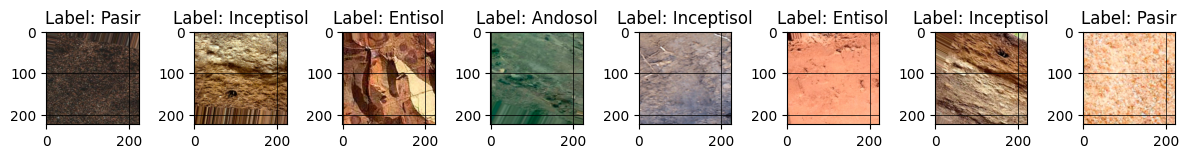

In [ ]:
def plot_images_with_labels(generator, num_images=5, image_size=(64, 64)):
    # Mengambil batch gambar dari generator
    images, labels = next(generator)

    # Mendapatkan kamus dari generator yang mengaitkan nilai numerik ke nilai string
    label_mapping = generator.class_indices

    # Menampilkan gambar-gambar beserta labelnya dengan grid
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.grid(True, color='black', linestyle='-', linewidth=0.5)  # Menambahkan grid

        # Mengonversi label numerik menjadi label string menggunakan kamus dari generator
        label_numeric = labels[i]
        label_string = list(label_mapping.keys())[list(label_mapping.values()).index(label_numeric)]

        plt.title(f"Label: {label_string}")  # Menampilkan label string
    plt.subplots_adjust(wspace=0.5)  # Menambahkan ruang antar subplot
    plt.tight_layout()  # Memastikan layout subplot teratur
    plt.show()

# Contoh penggunaan fungsi plot_images_with_labels dengan generator yang Anda miliki
plot_images_with_labels(iv3_model.train_generator, num_images=8, image_size=(100, 100))


In [ ]:
from keras.utils import plot_model

iv3_model.build(compile_config, custom_layer=custom_layers)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_3 (Dropout)         (None, 51200)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               26214912  
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 8)                

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05,
    'patience':5,
    'min_lr': 0.000002
}
iv3_model.train_model('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 2.0921 - acc: 0.2157
Epoch 1: val_acc improved from -inf to 0.38500, saving model to inceptionv3-saved-model-01-acc-0.38.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 30s 1s/step - loss: 2.0921 - acc: 0.2157 - val_loss: 1.6158 - val_acc: 0.3850 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.4807 - acc: 0.4831
Epoch 2: val_acc improved from 0.38500 to 0.63000, saving model to inceptionv3-saved-model-02-acc-0.63.hdf5
18/18 [==============================] - 21s 1s/step - loss: 1.4807 - acc: 0.4831 - val_loss: 1.0537 - val_acc: 0.6300 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.1031 - acc: 0.6132
Epoch 3: val_acc improved from 0.63000 to 0.66500, saving model to inceptionv3-saved-model-03-acc-0.67.hdf5
18/18 [==============================] - 17s 965ms/step - loss: 1.1031 - acc: 0.6132 - val_loss: 1.0292 - val_acc: 0.6650 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.9717 - acc: 0.6667
Epoch 4: val_acc improved from 0.66500 to 0.78500, saving model to inceptionv3-saved-model-04-acc-0.79.hdf

# Evaluation

In [ ]:
iv3_model.plot_training_history

<bound method Model.plot_training_history of <__main__.Model object at 0x79dfa4316fb0>>

4/4 [==============================] - 1s 272ms/step - loss: 0.1793 - acc: 0.9333
Loss of the model is -  0.17929832637310028
Accuracy of the model is -  93.33333373069763 %
4/4 [==============================] - 2s 222ms/step
              precision    recall  f1-score   support

     Aluvial       0.93      0.87      0.90        15
     Andosol       1.00      0.80      0.89        15
     Entisol       1.00      1.00      1.00        15
       Humus       0.93      0.93      0.93        15
  Inceptisol       0.79      1.00      0.88        15
       Kapur       1.00      0.93      0.97        15
     Laterit       0.94      1.00      0.97        15
       Pasir       0.93      0.93      0.93        15

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120

Confusion Matrix


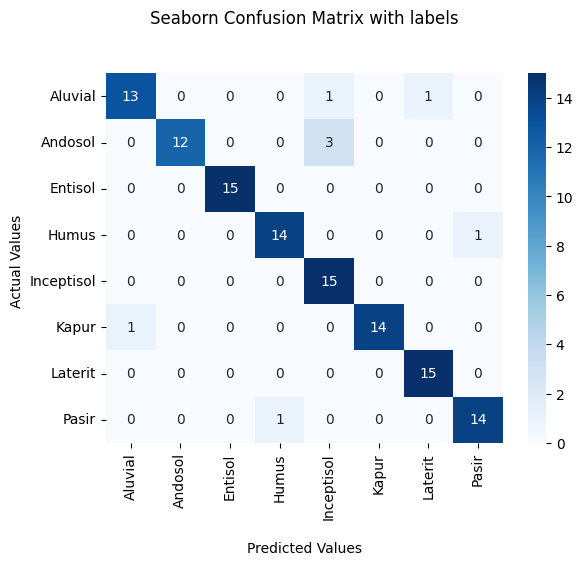

In [ ]:
iv3_model.evaluate()

./inceptionv3-saved-model-25-acc-0.99.hdf5
4/4 [==============================] - 3s 555ms/step - loss: 0.0864 - acc: 0.9750
Loss of the model is -  0.08643504977226257
Accuracy of the model is -  97.50000238418579 %
4/4 [==============================] - 2s 292ms/step
              precision    recall  f1-score   support

     Aluvial       0.88      1.00      0.94        15
     Andosol       1.00      1.00      1.00        15
     Entisol       1.00      1.00      1.00        15
       Humus       0.94      1.00      0.97        15
  Inceptisol       1.00      1.00      1.00        15
       Kapur       1.00      0.93      0.97        15
     Laterit       1.00      1.00      1.00        15
       Pasir       1.00      0.87      0.93        15

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

Confusion Matrix


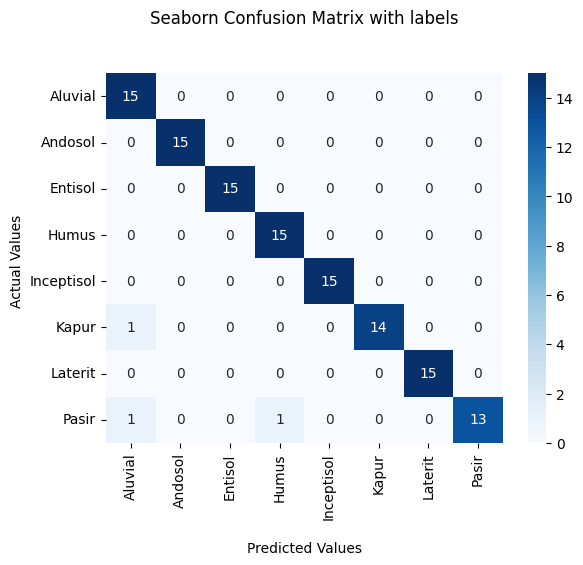

In [ ]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_weights('.')
iv3_model.evaluate_best_weights()

In [ ]:
target_dir = 'drive/Shareddrives/Bangkit'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-25-acc-0.99.hdf5 to drive/Shareddrives/Bangkit


In [ ]:
iv3_model.model.load_weights("/content/inceptionv3-saved-model-25-acc-0.99.hdf5")

# Testing Accuration

In [ ]:
# Load an image for testing
img_path = 'drive/Shareddrives/Bangkit/tester/inceptisol.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = iv3_preprocess_input(img_array)

# Make a prediction using your trained model
predictions = iv3_model.model.predict(img_array)

# Retrieve class labels from the data generator
class_labels = iv3_model.train_generator.class_indices

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Check if the predicted_class_index is within the valid range
if predicted_class_index < len(class_labels):
    predicted_class_label = [key for key, value in class_labels.items() if value == predicted_class_index][0]
    print(f"Predicted class: {predicted_class_label}")
else:
    print("Error: Predicted class index out of range.")


1/1 [==============================] - 0s 51ms/step
Predicted class: Inceptisol
